## This file filters the metadata

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zipfile
pd.options.mode.chained_assignment = None

Index(['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude',
       'scientific_name', 'common_name', 'author', 'license', 'rating', 'time',
       'url', 'filename'],
      dtype='object')


Text(0.5, 1.0, 'Sampling locations of original bird data')

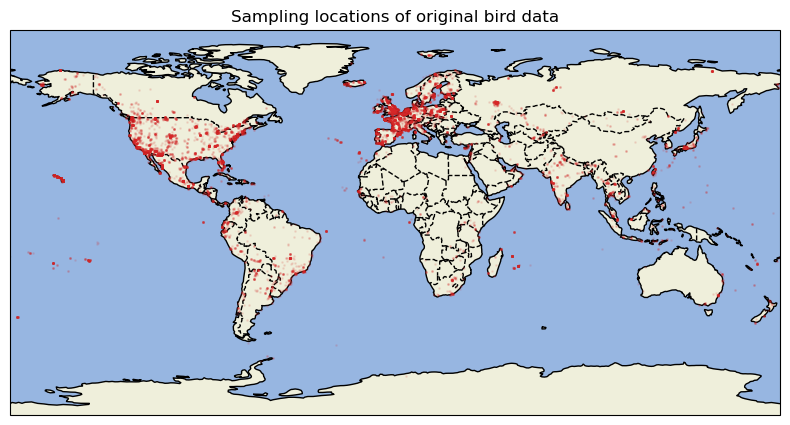

In [10]:
meta = pd.read_csv('train_metadata.csv')
print(meta.columns)

# Create a figure with an axis
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')

# Set extent to the whole world
ax.set_extent([-180, 180, -90, 90])
plt.plot(meta['longitude'], meta['latitude'], 'o', markersize=1, alpha=0.1, color='tab:red')
plt.title('Sampling locations of original bird data')

In [11]:
# We will not use data from authors who don't have enough contributions
num_contributions = 5
author_counts = meta['author'].value_counts()
uncommon_authors = author_counts[author_counts <= num_contributions].index.to_list()
meta = meta[~meta['author'].isin(uncommon_authors)]

In [12]:
# We will not use data with poor sound quality
good_quality = meta['rating'] > 2.
poor_quality = meta['rating'] <= 2.
print(f'Number of samples with poor quality: {sum(poor_quality)}')
print(f'Number of samples with good quality: {sum(good_quality)}')
meta = meta[good_quality]

Number of samples with poor quality: 1245
Number of samples with good quality: 11807


In [13]:
# We will ignore data with missing or invalid time

# hour-based
meta['hour_str'] = meta['time'].apply(lambda x: x.split(':')[0])
hour_issues = ['.','x','?','??','xx','am','pm','xx.xx','Dawn','020']
hour_issue_indices = np.argwhere(meta['hour_str'].isin(hour_issues)).squeeze()
meta = meta[~meta['hour_str'].isin(hour_issues)]
meta['hour_int'] = meta['hour_str'].astype(int)

# minute-based
meta['minute_str'] = meta['time'].apply(lambda x: x.split(':')[1])
minute_issue_indices = np.argwhere(meta['minute_str'].apply(lambda x: x[2:]).isin(['am','pm'])).squeeze()
meta = meta[~meta['minute_str'].apply(lambda x: x[2:]).isin(['am','pm'])]
meta['minute_int'] = meta['minute_str'].astype(int)

In [14]:
# We will remove data when there are multiple species in the sound
num_species = meta['secondary_labels'].apply(lambda x: len(x.split(',')))
multiple_species = num_species > 1
print(f'Number of samples with multiple species: {sum(multiple_species)}')
meta = meta[~multiple_species]

Number of samples with multiple species: 295


## Add some features to the data

<Axes: title={'center': 'Time of Day'}, xlabel='Time of Day', ylabel='Count'>

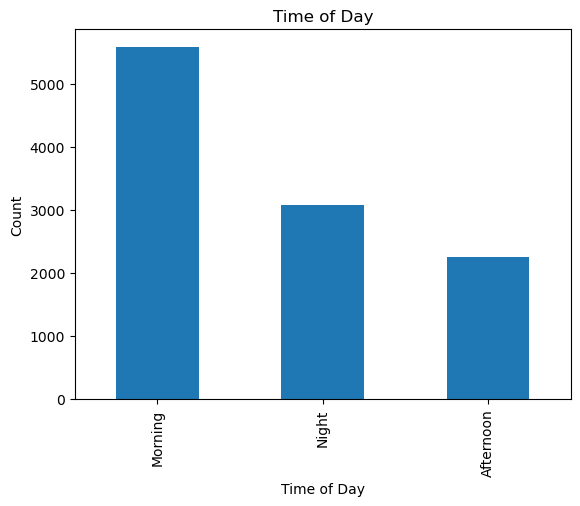

In [17]:
# Calculate the time of day
bins = [0, 6, 12, 18]  # Define the bin edges
labels = ['Night', 'Morning', 'Afternoon']  # Define the labels for the bins
meta['time_of_day'] = pd.cut(meta['hour_int'] % 18, bins=bins, labels=labels, right=False)
# meta[['hour_int', 'time_of_day']].head()
meta['time_of_day'].value_counts().plot(kind='bar', title='Time of Day', xlabel='Time of Day', ylabel='Count')

In [19]:

import re

# process the type column
meta['type_list'] = meta['type'].apply(lambda x: x.strip('[]\'').split(', ')).tolist()
meta['type_list'] = meta['type_list'].apply(lambda x: [_.strip('\'') for _ in x])
meta['type_list'] = meta['type_list'].apply(lambda x: [item.lower() for item in x])
meta['type_list'] = meta['type_list'].apply(lambda x: [item.replace(' ','') for item in x])

# gather nlp information
meta['flightcall'] = meta['type_list'].apply(lambda x: 1 if 'flightcall' in x else 0)
meta['call'] = meta['type_list'].apply(lambda x: 1 if 'call' in x else 0)
meta['song'] = meta['type_list'].apply(lambda x: 1 if 'song' in x else 0)
meta['nocturnalflightcall'] = meta['type_list'].apply(lambda x: 1 if 'nocturnalflightcall' in x else 0)
meta['alarmcall'] = meta['type_list'].apply(lambda x: 1 if 'alarmcall' in x else 0)
meta['beggingcall'] = meta['type_list'].apply(lambda x: 1 if 'beggingcall' in x else 0)
meta['male'] = meta['type_list'].apply(lambda x: 1 if 'male' in x else 0)
meta['female'] = meta['type_list'].apply(lambda x: 1 if 'female' in x else 0)
meta['sexuncertain'] = meta['type_list'].apply(lambda x: 1 if 'sexuncertain' in x else 0)
meta['adult'] = meta['type_list'].apply(lambda x: 1 if 'adult' in x else 0)
meta['juvenile'] = meta['type_list'].apply(lambda x: 1 if 'juvenile' in x else 0)
meta['lifestageuncertain'] = meta['type_list'].apply(lambda x: 1 if 'lifestageuncertain' in x else 0)

# combine some nlp info with regular expressions
meta['flight_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'flight', item) for item in x) else 0)
meta['song_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'song', item) for item in x) else 0)
meta['nocturnal_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'nocturnal', item) for item in x) else 0)
meta['alarm_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'alarm', item) for item in x) else 0)
meta['wing_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'wing', item) for item in x) else 0)
meta['begging_any'] = meta['type_list'].apply(lambda x: 1 if any(re.search(r'begging', item) for item in x) else 0)

In [20]:
meta[['flight_any', 'song_any', 'nocturnal_any', 'alarm_any', 'wing_any','begging_any']].sum()

flight_any       3327
song_any         2702
nocturnal_any    1226
alarm_any         607
wing_any          185
begging_any       233
dtype: int64

In [21]:
meta[['male','female','sexuncertain']].sum()

male            1290
female           663
sexuncertain     774
dtype: int64

In [22]:
meta.to_csv('train_metadata_cleaned.csv', index=False)

Text(0.5, 1.0, 'Sampling locations of filtered bird data')

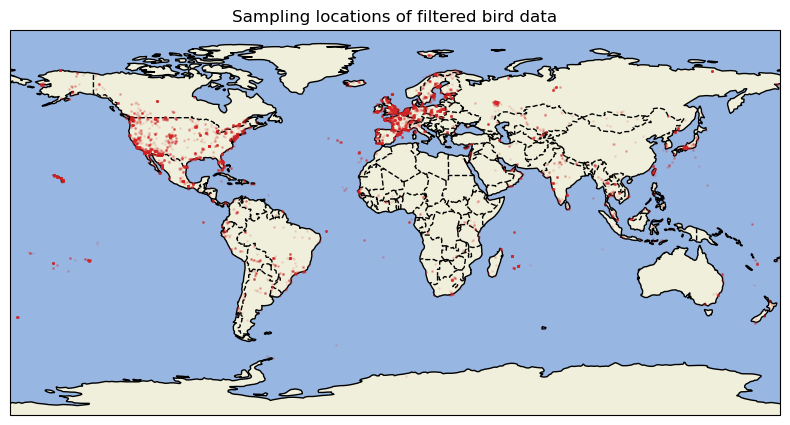

In [16]:
# Create a figure with an axis
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='--')

# Set extent to the whole world
ax.set_extent([-180, 180, -90, 90])
plt.plot(meta['longitude'], meta['latitude'], 'o', markersize=1, alpha=0.1, color='tab:red')
plt.title('Sampling locations of filtered bird data')